In [7]:
import mesa
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
class DataProvider(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.data_quantity = self.model.num_data
        self.wealth = 0

In [12]:
class Participants(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_token = False
        self.purchase_price = None

        self.wealth = int(self.random.normalvariate(100, 20))
        self.wealth = max(0, self.wealth)
        self.utility = int(self.random.normalvariate(80, 15))
        self.utility = max(0, self.utility)
        
        self.is_listing = False
        self.listing_price = None
        self.has_ever_held_token = False

    def decide_sell_price(self):
        if not self.model.sell_orders:
            return self.purchase_price * 1.1
        
        lowest_price = self.model.sell_orders[0]['price']
        price_to_list = int(lowest_price * 0.99)
        return price_to_list

    def decide_and_list_if_applicable(self):
        if self.has_token and not self.is_listing:
            if self.random.random() < self.model.listing_probability:
                price_to_list = self.decide_sell_price()
                if price_to_list is not None:
                    self.model.place_sell_order(price_to_list, self)
                    self.is_listing = True
                    self.listing_price = price_to_list

    def buy_if_interested(self):
        if self.has_ever_held_token:
            return

        if not self.model.sell_orders:
            return

        cheapest_order = self.model.sell_orders[0]
        price = cheapest_order['price']
        seller = cheapest_order['agent']

        if self.utility >= price and self.wealth >= price:
            self.model.execute_trade(self, seller, price)

    def discount_price(self):
        current_step = self.model.steps
        if self.is_listing:
            for order in self.model.sell_orders:
                if order['agent'] == self:
                    if order['step_created'] < current_step - 5:
                        discounted_price = int(order['price'] * 0.9)
                        order['price'] = discounted_price
                        order['step_created'] = current_step
                        self.listing_price = discounted_price

class DataMarket(Model):
    def __init__(self, num_participants, num_data, initial_price, listing_probability, royalty_rate, seed=None):
        super().__init__(seed=seed)
        self.num_participants = num_participants
        self.num_data = num_data
        self.initial_price = initial_price
        self.listing_probability = listing_probability
        self.steps = 0
        self.royalty_rate = royalty_rate
        self.sell_orders = []
        self.trade_history = []

        self.provider = DataProvider.create_agents(self, n=1)[0]
        self.participants = Participants.create_agents(self, n=self.num_participants)

        for _ in range(self.provider.data_quantity):
            self.place_sell_order(self.initial_price, self.provider)

        self.datacollector = DataCollector(
            model_reporters={
                "total_sell_orders": lambda m: len(m.sell_orders),
                "provider_sell_orders": lambda m: len([o for o in m.sell_orders if isinstance(o['agent'], DataProvider)]),
                "average_price": lambda m: np.mean([order['price'] for order in m.sell_orders]) if m.sell_orders else 0
            },
            agent_reporters={
                "wealth": "wealth",
                "has_token": "has_token",
                "is_listing": "is_listing"
            }
        )
        self.datacollector.collect(self)

    def place_sell_order(self, price, agent):
        self.sell_orders.append({'price': price, 'agent': agent, 'step_created': self.steps})
        self.sell_orders.sort(key=lambda x: x['price'])

    def execute_trade(self, buyer, seller, price):
        trade_log = {
            'step': self.steps,
            'buyer_id': buyer.unique_id,
            'seller_id': seller.unique_id,
            'price': price,
            'seller_type': 'DataProvider' if isinstance(seller, DataProvider) else 'Participant'
        }
        self.trade_history.append(trade_log)

        buyer.wealth -= price
        buyer.has_token = True
        buyer.purchase_price = price
        buyer.has_ever_held_token = True

        if isinstance(seller, DataProvider):
            seller.wealth += price
            seller.data_quantity -= 1
        else:
            royalty = int(price * self.royalty_rate)
            seller.wealth += price - royalty
            self.provider.wealth += royalty
            seller.has_token = False
            seller.is_listing = False
            seller.listing_price = None

        self.sell_orders.pop(0)

    def step(self):
        self.participants.shuffle_do("decide_and_list_if_applicable")
        self.participants.shuffle_do("discount_price")
        self.participants.shuffle_do("buy_if_interested")
        self.datacollector.collect(self)

In [23]:
model = DataMarket(num_participants=100, num_data=100, initial_price=80, listing_probability=0.5, royalty_rate = 0.05, seed=42)

for i in range(100):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()
trade_history_df = pd.DataFrame(model.trade_history)

/var/folders/5r/f_b8tt1n79vbcql6f1yp4p9w0000gn/T/ipykernel_9055/1403867341.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  }).fillna(method='ffill').fillna(0)


--- Analysis Summary ---
      Average Trade Price  DataProvider Orders  Participant Orders  DataProvider Wealth  Experienced Participants
Step                                                                                                             
0                     0.0                  100                   0                    0                         0
1                    80.0                   64                   0                 2880                        36
2                    67.5                   64                   2                 2938                        56
3                    66.0                   64                   7                 2977                        69
4                    62.5                   64                  12                 3005                        79
5                    59.0                   64                  16                 3027                        88
6                    57.0                   64                 

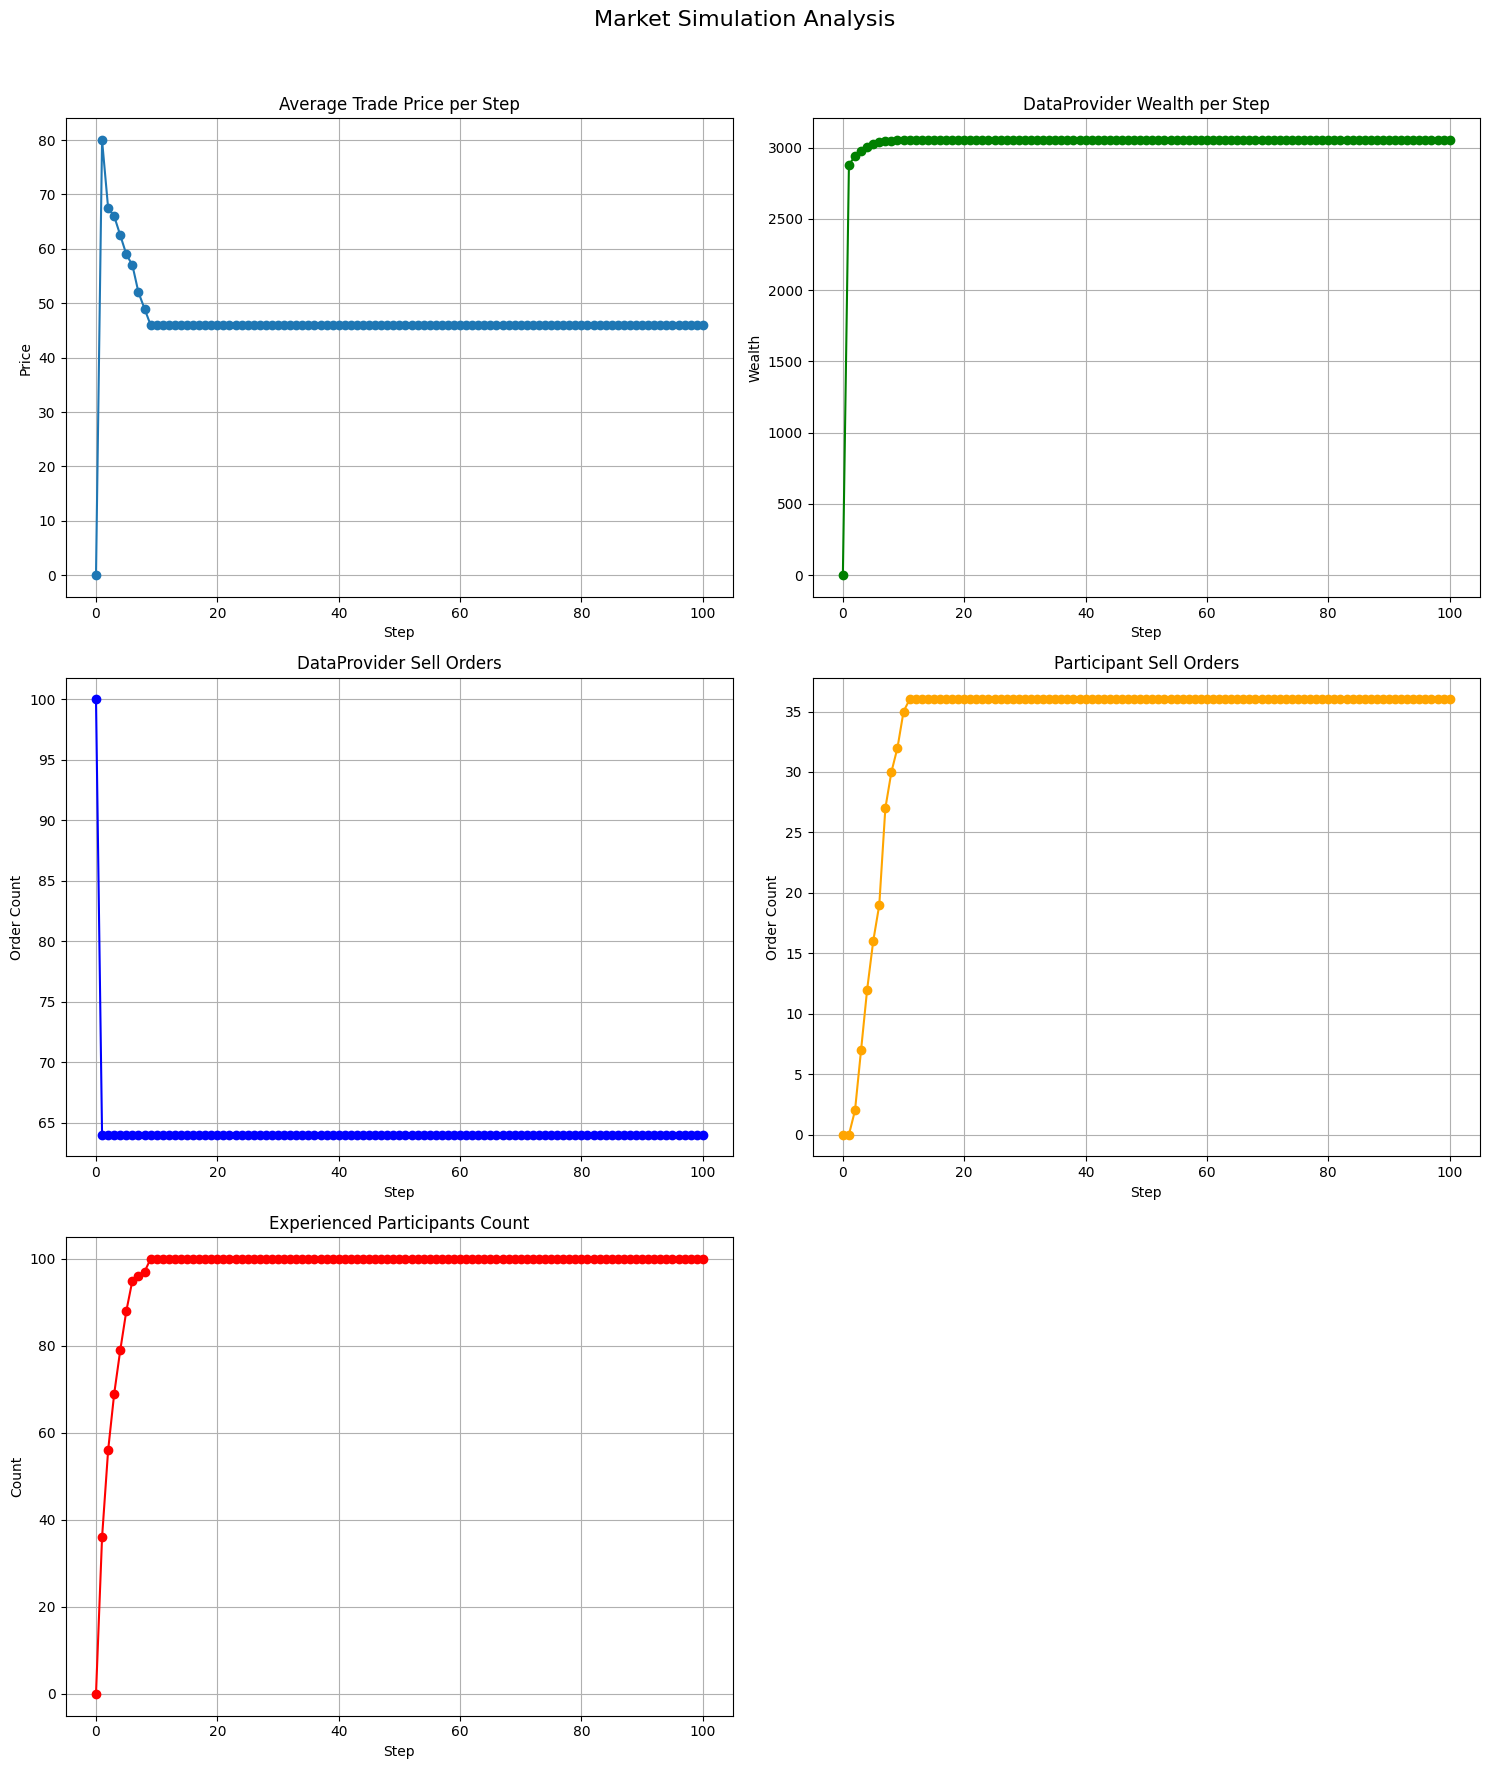

In [24]:
# --- 指標の計算 ---
avg_trade_price = trade_history_df.groupby('step')['price'].mean()
provider_orders_count = model_data['provider_sell_orders']
participant_orders_count = model_data['total_sell_orders'] - provider_orders_count

if 1 in agent_data.index.get_level_values('AgentID'):
    provider_wealth = agent_data.xs(1, level='AgentID')['wealth']
else:
    provider_trades = trade_history_df[trade_history_df['seller_id'] == 1]
    if not provider_trades.empty:
        provider_wealth = provider_trades.groupby('step')['price'].sum().cumsum()
    else:
        provider_wealth = pd.Series(0, index=model_data.index)
    provider_wealth = provider_wealth.reindex(model_data.index, method='ffill').fillna(0)

experienced_participants = []
for step in model_data.index:
    buyers = trade_history_df[(trade_history_df['step'] <= step) & (trade_history_df['buyer_id'] != 1)]['buyer_id'].unique()
    experienced_participants.append(len(buyers))
experienced_participants = pd.Series(experienced_participants, index=model_data.index)

summary_df = pd.DataFrame({
    'Average Trade Price': avg_trade_price,
    'DataProvider Orders': provider_orders_count,
    'Participant Orders': participant_orders_count,
    'DataProvider Wealth': provider_wealth,
    'Experienced Participants': experienced_participants
}).fillna(method='ffill').fillna(0)
summary_df.index.name = 'Step'

print("--- Analysis Summary ---")
print(summary_df.to_string())

# --- グラフの描画 ---
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Market Simulation Analysis', fontsize=16)

# 1. 平均取引価格
summary_df['Average Trade Price'].plot(ax=axes[0, 0], title='Average Trade Price per Step', grid=True, marker='o')
axes[0, 0].set_ylabel('Price')

# 2. DataProviderの資産
summary_df['DataProvider Wealth'].plot(ax=axes[0, 1], title='DataProvider Wealth per Step', grid=True, marker='o', color='green')
axes[0, 1].set_ylabel('Wealth')

# 3. DataProviderの売り注文数
summary_df['DataProvider Orders'].plot(ax=axes[1, 0], title='DataProvider Sell Orders', grid=True, marker='o', color='blue')
axes[1, 0].set_ylabel('Order Count')

# 4. Participantの売り注文数
summary_df['Participant Orders'].plot(ax=axes[1, 1], title='Participant Sell Orders', grid=True, marker='o', color='orange')
axes[1, 1].set_ylabel('Order Count')

# 5. データ保有経験者数
summary_df['Experienced Participants'].plot(ax=axes[2, 0], title='Experienced Participants Count', grid=True, marker='o', color='red')
axes[2, 0].set_ylabel('Count')

# 6. 空のプロット
axes[2, 1].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()